# Import necessary packages

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# Set torch seed
torch.manual_seed(2023)

In [3]:
# Initialize Hyperparameters
HD_DIMENSION = 40000
NUM_CLASSES = 47
THRESHOLD = 0.0
BATCH_SIZE = 512
IMG_LEN = 28 * 28

In [4]:
# Load data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hd_device = torch.device('cpu')
# device = torch.device('mps')

print('Using device:', device)

# Load MNIST Data

# Flip image horizontally, rotate 90 degrees, and convert to tensor
transform = transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                lambda img: torchvision.transforms.functional.hflip(img),
                                torchvision.transforms.ToTensor()])


train_data = torchvision.datasets.EMNIST(root='data', train=True, transform=transform, download=True, split='balanced')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

test_data = torchvision.datasets.EMNIST(root='data', train=False, transform=transform, download=True, split='balanced')
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

Using device: cuda


In [5]:
# Function to generate HD vectors
def generate_hd_vectors(images, proj):

    # Adjust proj to sit between -1 and 1
    # proj = proj * 2 - 1
    proj *= 2
    proj -= 1

    # Send images to device
    images = images.to(hd_device)

    # Generate hypervectors and create binary vector
    hd_vectors = torch.sign(images @ proj.T)
    
    return hd_vectors.to(hd_device)

# Classify hd vectors using cosine similarity
def classify_hd_vectors(hd_vectors, hd_memory):
    distances = torch.cdist(hd_vectors, hd_memory, p=2)
    
    # Find the index of the minimum distance
    min_distances, min_indices = torch.min(distances, dim=1)
    return min_indices.to(hd_device)

def create_hd_memory(hd_vectors, labels, HD_DIMENSION):
    # Initialize HD Memory for classes
    hd_memory = torch.zeros((NUM_CLASSES, HD_DIMENSION), device=hd_device)

    # Create HD Memory
    for i, vec in enumerate(hd_vectors):
        hd_memory[train_data.targets[i]] += vec

    return torch.sign(hd_memory)


In [6]:
# Create projection matrix
proj = torch.rand((HD_DIMENSION, IMG_LEN), device=hd_device, dtype=torch.float32)

# Create hyper vectors
hd_vectors = generate_hd_vectors(train_data.data.view(train_data.data.shape[0], -1) / 255, proj)

hd_memory = create_hd_memory(hd_vectors, train_data.targets, HD_DIMENSION)


In [7]:
# Convert to binary for faster computation
def to_binary(hd_vectors, hd_memory):
    hd_vectors = (hd_vectors == 1).to(torch.float32)
    hd_memory = (hd_memory == 1).to(torch.float32)
    return hd_vectors, hd_memory

hd_vectors, hd_memory = to_binary(hd_vectors, hd_memory)

In [8]:
# Testing training data
classifications = classify_hd_vectors(hd_vectors, hd_memory)

correct = torch.sum(classifications == train_data.targets.to(hd_device))
total = len(train_data.targets)
print(f"Accuracy on training data: {correct / total * 100}%")

Accuracy on training data: 52.53546142578125%


In [9]:
# Testing on test data
hd_vectors_test = generate_hd_vectors(test_data.data.view(test_data.data.shape[0], -1) / 255, proj)
hd_vectors_test = (hd_vectors_test == 1).to(torch.float32)

correct = 0
total = 0

classifications = classify_hd_vectors(hd_vectors_test, hd_memory)

for i, classification in enumerate(classifications):
    if classification == test_data.targets[i]:
        correct += 1
    total += 1

print(f"Accuracy on test data: {correct / total * 100}%")


Accuracy on test data: 2.127659574468085%


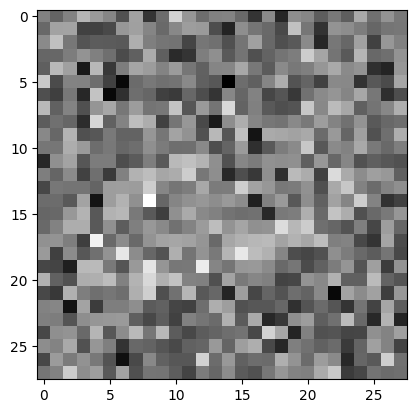

In [10]:
# Compare accuracy when applying random noise to images
noise_level = 0.1

noise_matrix = torch.randn((test_data.data.shape[0], IMG_LEN), device=hd_device) * noise_level

# Plot noise matrix
noisy_test_data = (test_data.data.view(test_data.data.shape[0], -1) / 255).to(hd_device) + noise_matrix

plt.imshow(noisy_test_data[0].view(28, 28).cpu(), cmap='gray')

hd_vectors_noise = generate_hd_vectors(noisy_test_data, proj)
hd_vectors_noise = (hd_vectors_noise == 1).to(torch.float32)
    

In [11]:
# Test noisy test data
classifications = classify_hd_vectors(hd_vectors_noise, hd_memory)

correct = torch.sum(classifications == test_data.targets.to(hd_device))
total = len(test_data.targets)
print(f"Accuracy on test data with noise: {correct / total * 100}%")

Accuracy on test data with noise: 2.5319149494171143%


# Defining and training an MLP for MNIST classification

In [12]:
# Create simple neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(IMG_LEN, 512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, NUM_CLASSES)
    
    def forward(self, x):
        x = x.view(-1, IMG_LEN)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x
    
# Create neural network
model = NeuralNetwork().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train neural network
num_epochs = 30
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (BATCH_SIZE, 28*28)
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss and accuracy after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%')


Epoch [1/30], Loss: 0.8368
Accuracy: 70.16%
Epoch [2/30], Loss: 0.8189
Accuracy: 77.40%
Epoch [3/30], Loss: 0.6036
Accuracy: 80.04%
Epoch [4/30], Loss: 0.5244
Accuracy: 82.02%
Epoch [5/30], Loss: 0.5655
Accuracy: 83.41%
Epoch [6/30], Loss: 0.4966
Accuracy: 84.07%
Epoch [7/30], Loss: 0.5101
Accuracy: 85.09%
Epoch [8/30], Loss: 0.5331
Accuracy: 85.78%
Epoch [9/30], Loss: 0.3464
Accuracy: 85.87%
Epoch [10/30], Loss: 0.4261
Accuracy: 86.45%
Epoch [11/30], Loss: 0.5167
Accuracy: 86.97%
Epoch [12/30], Loss: 0.4008
Accuracy: 87.09%
Epoch [13/30], Loss: 0.3258
Accuracy: 87.57%
Epoch [14/30], Loss: 0.4088
Accuracy: 87.75%
Epoch [15/30], Loss: 0.3383
Accuracy: 88.41%
Epoch [16/30], Loss: 0.2451
Accuracy: 88.87%
Epoch [17/30], Loss: 0.3822
Accuracy: 88.60%
Epoch [18/30], Loss: 0.2976
Accuracy: 88.98%
Epoch [19/30], Loss: 0.2532
Accuracy: 89.17%
Epoch [20/30], Loss: 0.2738
Accuracy: 89.47%
Epoch [21/30], Loss: 0.1917
Accuracy: 89.66%
Epoch [22/30], Loss: 0.3219
Accuracy: 89.80%
Epoch [23/30], Loss

In [13]:
# Testing loop to evaluate the model using test_loader
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 85.91%


# Define and train a Vision Transformer for MNIST classification

In [14]:
from vit_pytorch import ViT

v = ViT(
    image_size = 28,
    patch_size = 7,
    num_classes = NUM_CLASSES,
    dim = 256,
    depth = 6,
    heads = 16,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 1
).to(device)

# Train the model
import torch.optim as optim

optimizer = optim.Adam(v.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 30

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = v(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = v(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%')

Epoch [1/30], Loss: 0.6683
Accuracy: 80.20%
Epoch [2/30], Loss: 0.5002
Accuracy: 83.97%
Epoch [3/30], Loss: 0.4413
Accuracy: 85.72%
Epoch [4/30], Loss: 0.3454
Accuracy: 85.77%
Epoch [5/30], Loss: 0.4496
Accuracy: 86.62%
Epoch [6/30], Loss: 0.4538
Accuracy: 87.77%
Epoch [7/30], Loss: 0.4138
Accuracy: 88.13%
Epoch [8/30], Loss: 0.4826
Accuracy: 88.37%
Epoch [9/30], Loss: 0.2566
Accuracy: 88.55%
Epoch [10/30], Loss: 0.4740
Accuracy: 88.37%
Epoch [11/30], Loss: 0.3311
Accuracy: 88.70%
Epoch [12/30], Loss: 0.2245
Accuracy: 89.50%
Epoch [13/30], Loss: 0.3561
Accuracy: 89.59%
Epoch [14/30], Loss: 0.2713
Accuracy: 89.97%
Epoch [15/30], Loss: 0.2406
Accuracy: 89.82%
Epoch [16/30], Loss: 0.2818
Accuracy: 90.16%
Epoch [17/30], Loss: 0.1818
Accuracy: 90.36%
Epoch [18/30], Loss: 0.2785
Accuracy: 90.95%
Epoch [19/30], Loss: 0.2439
Accuracy: 90.84%
Epoch [20/30], Loss: 0.2767
Accuracy: 91.03%
Epoch [21/30], Loss: 0.3064
Accuracy: 91.44%
Epoch [22/30], Loss: 0.2159
Accuracy: 91.41%
Epoch [23/30], Loss

# Test high dimensional vector MNIST classification with varying dimensions and noise levels

In [15]:
# Test noisy test data with varying noise levels
noise_levels = np.arange(0, 1, 0.02)

# Make varying levels of noise from 10000 upto HD_DIMENSION
hd_dims = np.arange(10000, HD_DIMENSION, 10000)

total = len(test_data.targets)
hd_history = {}

# Initialize label-wise counters
label_counter = {i: 0 for i in range(NUM_CLASSES)}
label_total = {i: 0 for i in range(NUM_CLASSES)}

for hd_dim in hd_dims:
    # Create projection matrix
    proj = torch.rand((hd_dim, IMG_LEN), device=hd_device, dtype=torch.float32)

    # Create hyper vectors
    hd_vectors = generate_hd_vectors(train_data.data.view(train_data.data.shape[0], -1) / 255, proj)

    # Create HD Memory
    hd_memory = create_hd_memory(hd_vectors, train_data.targets, hd_dim)

    # Convert to binary for faster computation
    hd_vectors, hd_memory = to_binary(hd_vectors, hd_memory)

    accuracies_hd = []
    for noise_level in noise_levels:
        noise_matrix = torch.randn((test_data.data.shape[0], IMG_LEN), device=hd_device) * noise_level

        # Plot noise matrix
        noisy_test_data = (test_data.data.view(test_data.data.shape[0], -1) / 255).to(hd_device) + noise_matrix

        hd_vectors_noise = generate_hd_vectors(noisy_test_data, proj)
        hd_vectors_noise = (hd_vectors_noise == 1).to(torch.float32)

        classifications = classify_hd_vectors(hd_vectors_noise, hd_memory)

        correct = torch.sum(classifications.cpu() == test_data.targets)

        # Update label-wise counters
        for true, pred in zip(test_data.targets, classifications.cpu()):
            label_total[true.item()] += 1
            if true == pred:
                label_counter[true.item()] += 1
                
        accuracies_hd.append(correct / total * 100)

    hd_history[hd_dim] = accuracies_hd

# Calculate and print label-wise accuracies
label_accuracies = {label: (label_counter[label] / label_total[label]) * 100 for label in label_counter}
print("Label-wise accuracies:", label_accuracies)


Label-wise accuracies: {0: 0.0016666666666666668, 1: 0.42166666666666663, 2: 0.0, 3: 0.008333333333333333, 4: 0.006666666666666667, 5: 0.0033333333333333335, 6: 0.005, 7: 33.348333333333336, 8: 0.0016666666666666668, 9: 0.051666666666666666, 10: 0.0, 11: 0.0, 12: 0.013333333333333334, 13: 33.32333333333333, 14: 0.0, 15: 0.0, 16: 0.005, 17: 0.0016666666666666668, 18: 0.4033333333333333, 19: 0.051666666666666666, 20: 0.0, 21: 0.06, 22: 0.075, 23: 0.008333333333333333, 24: 0.0016666666666666668, 25: 0.051666666666666666, 26: 0.005, 27: 0.0, 28: 0.0, 29: 0.19, 30: 0.0016666666666666668, 31: 0.006666666666666667, 32: 0.06333333333333332, 33: 0.011666666666666667, 34: 0.051666666666666666, 35: 0.0, 36: 0.0016666666666666668, 37: 0.021666666666666667, 38: 0.015, 39: 0.0, 40: 0.051666666666666666, 41: 0.0, 42: 33.324999999999996, 43: 0.005, 44: 0.005, 45: 0.02666666666666667, 46: 0.018333333333333333}


# Test MLP with varying noise levels

In [16]:
# Test neural network with progressively more noise
accuracies_net = []

for noise_level in noise_levels:

    # Test noisy test data
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)

            # Add noise to images
            noise_matrix = torch.randn((images.shape[0], IMG_LEN), device=device) * noise_level
            images = images + noise_matrix

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracies_net.append(correct / total * 100)


# Test ViT with varying levels of noise

In [ ]:
acc_vit = []

for noise_level in noise_levels:
    
        # Test noisy test data
        correct = 0
        total = 0
    
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
    
                # Add noise to images
                noise_matrix = torch.randn((images.shape[0], 1, 28, 28), device=device) * noise_level
                images = images + noise_matrix
    
                outputs = v(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        acc_vit.append(correct / total * 100)

# Display MNIST images with noise to get an idea of how noisy the images are to the human eye

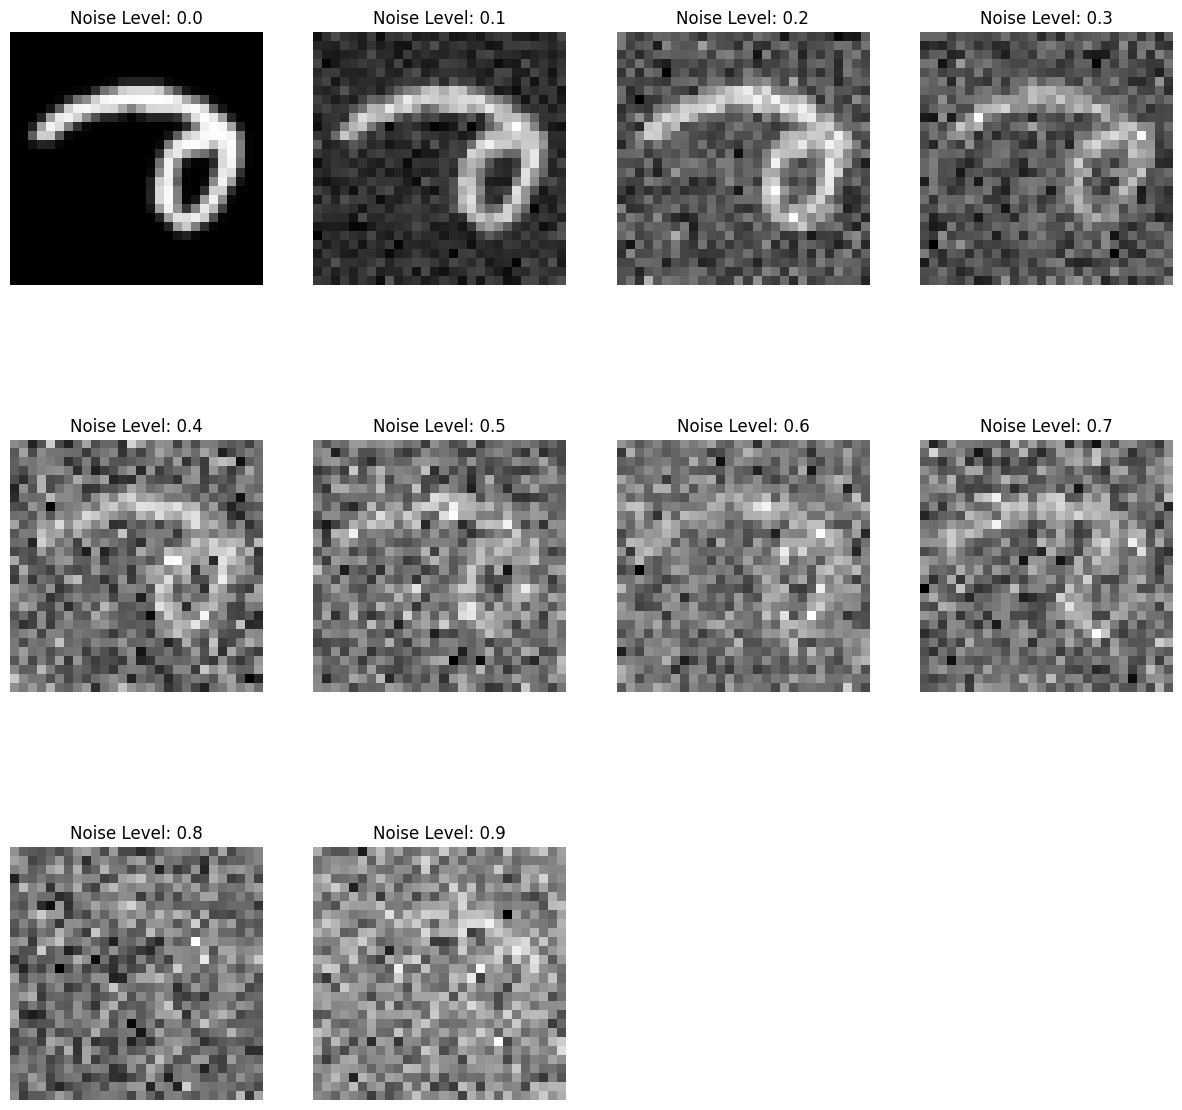

In [ ]:
# Plot a random image from the test set with the various noise levels
plt.figure(figsize=(15, 15))

index = torch.randint(0, len(test_data.targets), size=(1,)).item()
for i, noise_level in enumerate(np.arange(0, 1, 0.1)):
    noise_matrix = torch.randn((test_data.data.shape[0], IMG_LEN)) * noise_level

    # Create noisy image
    noisy_test_data = (test_data.data.view(test_data.data.shape[0], -1) / 255) + noise_matrix

    # Create subplot and display the image
    plt.subplot(3, 4, i + 1)  # Assuming you have 10 images (0, 0.1, ..., 0.9), adjust the dimensions as necessary
    plt.imshow(noisy_test_data[index].view(28, 28), cmap='gray')
    plt.title(f'Noise Level: {noise_level:.1f}')
    plt.axis('off')  # Turn off axis numbers and ticks

plt.show()

In [ ]:
for hd_dim in hd_history:
    plt.plot(noise_levels, hd_history[hd_dim])
plt.plot(noise_levels, accuracies_net)
plt.plot(noise_levels, acc_vit)
legend = []
plt.legend(["HD Dimension: 10000", "HD Dimension: 20000", "HD Dimension: 30000", "HD Dimension: 40000", "HD Dimension: 50000", "HD Dimension: 60000", "HD Dimension: 70000", "Neural Network"])
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Noise Level for Neural Network")
plt.grid()